#1. Environment setup and data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/SPH6004-group assignment/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0.zip"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796330/s51132520/a9e8e82e-d90e58a7-f28de941-f1e980a8-2d71737a.tfrecord  
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796330/s53980046/f96a7c3b-743943f1-f33e2e08-7325391b-3db36721.tfrecord  
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796474/s52981359/d298b8d4-f51825fb-bb351c1e-46f32718-8be91e1f.tfrecord  
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796562/s59195152/665a0427-215b7179-410d67a5-dd6b2252-90c7075a.tfrecord  
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796678/s54648930/0f3b6201-fb94a849-0af7fdcb-eeba98c8-2e6aa992.tfrecord  
  inflating: generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p19/p19796796/s57422647/37c6435c-cad30869-447b882a-c3fc05

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import tensorflow as tf

#2. Dataset Class definition

In [ ]:
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
    ]

    split_ratio = [0.8, 0.1, 0.1]

    def __init__(self, embedpath, csvpath, metacsvpath, views=["PA"], seed=0, unique_patients=True, mode="train"):
        super().__init__()
        np.random.seed(seed)
        self.embedpath = embedpath
        self.csvpath = csvpath
        self.metacsvpath = metacsvpath
        self.mode = mode
        self.views = views

        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.full_csv = self.csv.join(self.metacsv).reset_index()

        self.full_csv["view"] = self.full_csv["ViewPosition"]
        self._filter_views()

        if unique_patients:
            self.full_csv = self.full_csv.groupby("subject_id").first().reset_index()

        n_samples = len(self.full_csv)
        split_idx = [
            int(n_samples * self.split_ratio[0]),
            int(n_samples * (self.split_ratio[0] + self.split_ratio[1]))
        ]
        if mode == "train":
            self.full_csv = self.full_csv.iloc[:split_idx[0]]
        elif mode == "valid":
            self.full_csv = self.full_csv.iloc[split_idx[0]:split_idx[1]]
        elif mode == "test":
            self.full_csv = self.full_csv.iloc[split_idx[1]:]

        self._process_labels()

    def _filter_views(self):
        if '*' not in self.views:
            self.full_csv = self.full_csv[self.full_csv["view"].isin(self.views)]

    def _process_labels(self):
        labels = []
        no_finding_idx = self.pathologies.index("No Finding")
        healthy_mask = (self.full_csv["No Finding"] == 1).values

        for idx, pathology in enumerate(self.pathologies):
            if pathology in self.full_csv.columns:
                col_data = self.full_csv[pathology].copy()
                col_data.replace(-1, np.nan, inplace=True)
                if idx == no_finding_idx:
                    col_data.fillna(0, inplace=True)
                else:
                    col_data.loc[healthy_mask] = 0
                labels.append(col_data.values)

        self.labels = np.array(labels).T.astype(np.float32)

    def __len__(self):
        return len(self.full_csv)

    def __getitem__(self, idx):

        row = self.full_csv.iloc[idx]

        try:

            labels = torch.as_tensor(self.labels[idx], dtype=torch.float32)

            embed_path = os.path.join(
                self.embedpath,
                f"p{str(row['subject_id'])[:2]}",
                f"p{str(row['subject_id'])}",
                f"s{str(row['study_id'])}",
                f"{str(row['dicom_id'])}.tfrecord"
            )


            embedding = self._load_embedding(embed_path)

            return {
                "embedding": embedding,
                "labels": labels,
                "metadata": {
                    "subject_id": str(row["subject_id"]),
                    "study_id": str(row["study_id"]),
                    "dicom_id": str(row["dicom_id"]),
                    "original_index": idx
                }
            }

        except Exception as e:
            self.logger.warning(f"Skipping sample {idx} (Error: {str(e)})")
            return {
                "embedding": torch.zeros(1376, dtype=torch.float32),
                "labels": torch.full((14,), float('nan')),
                "metadata": {
                    "error": str(e),
                    "original_index": idx,
                    "is_dummy": True
                }
            }

    def _load_embedding(self, path):
        """Load the TFRecord embedding file"""
        try:
            dataset = tf.data.TFRecordDataset(path)
            for raw_record in dataset:
                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                embedding = np.array(
                    example.features.feature['embedding'].float_list.value,
                    dtype=np.float32
                )

                if len(embedding) != 1376:
                    raise ValueError(f"The embedding length should be 1376, but got: {len(embedding)}")

                return torch.from_numpy(embedding).float()

            raise ValueError("The TFRecord file is empty")
        except Exception as e:
            raise RuntimeError(f"Failed to load: {path} | Error: {str(e)}")

    def analyze_dataset(self):
        print("=" * 50)
        print(f"Dataset analysis report (Mode: {self.mode})")
        print("=" * 50)
        print(f"Total number of samples: {len(self):,}\n")

        label_df = pd.DataFrame(self.labels, columns=self.pathologies)
        print("Label distribution (including positive, negative, and unlabeled):")
        for pathology in self.pathologies:
            print(f"\n{pathology}:")
            print(f"  Positive(1): {label_df[pathology].sum():>6} ({label_df[pathology].mean() * 100:.1f}%)")
            print(f"  Negative(0): {(label_df[pathology] == 0).sum():>6} ({(label_df[pathology] == 0).mean() * 100:.1f}%)")
            print(f"  Unlabeled:  {label_df[pathology].isna().sum():>6} ({label_df[pathology].isna().mean() * 100:.1f}%)")

        print("\nPreview of labels for the first 5 samples:")
        for i in range(min(5, len(self))):
            print(f"\nSample {i}:")
            raw_data = self.full_csv.iloc[i][self.pathologies]
            print("[Original labels]")
            print(raw_data.replace({-1: "NaN", np.nan: "NaN"}).to_string())
            print("\n[Processed labels]")
            processed = pd.Series(self.labels[i], index=self.pathologies)
            print(processed.replace({np.nan: "NaN"}).to_string())

#3. Dataset Initialization and analysis

In [ ]:
if __name__ == "__main__":
    dataset = MIMIC_Embed_Dataset(
        embedpath="/content/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files",
        csvpath="/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-2.0.0-chexpert.csv",
        metacsvpath="/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-2.0.0-metadata.csv",
        mode="train"
    )

    dataset.analyze_dataset()

    print("\nVerify the data split:")
    total = len(dataset)
    train_size = int(total * 0.8)
    valid_size = int(total * 0.1)
    test_size = total - train_size - valid_size
    print(f"Theoretical split: {train_size} | {valid_size} | {test_size}")
    print(f"Actual split: {len(dataset.full_csv)} (Current mode: {dataset.mode})")

Dataset analysis report (Mode: train)
Total number of samples: 36,502

Label distribution (including positive, negative, and unlabeled):

Enlarged Cardiomediastinum:
  Positive(1):  553.0 (2.1%)
  Negative(0):  25213 (69.1%)
  Unlabeled:   10736 (29.4%)

Cardiomegaly:
  Positive(1): 2982.0 (10.3%)
  Negative(0):  25852 (70.8%)
  Unlabeled:    7668 (21.0%)

Lung Opacity:
  Positive(1): 4306.0 (14.7%)
  Negative(0):  24953 (68.4%)
  Unlabeled:    7243 (19.8%)

Lung Lesion:
  Positive(1): 1050.0 (4.1%)
  Negative(0):  24834 (68.0%)
  Unlabeled:   10618 (29.1%)

Edema:
  Positive(1):  928.0 (3.3%)
  Negative(0):  26884 (73.7%)
  Unlabeled:    8690 (23.8%)

Consolidation:
  Positive(1):  650.0 (2.5%)
  Negative(0):  25851 (70.8%)
  Unlabeled:   10001 (27.4%)

Pneumonia:
  Positive(1): 1745.0 (6.1%)
  Negative(0):  26674 (73.1%)
  Unlabeled:    8083 (22.1%)

Atelectasis:
  Positive(1): 3222.0 (11.5%)
  Negative(0):  24778 (67.9%)
  Unlabeled:    8502 (23.3%)

Pneumothorax:
  Positive(1):  45

#4. Check the embedding dimension

In [ ]:
import os
import tensorflow as tf
import numpy as np

def check_single_tfrecord_dimension(tfrecord_path):
    try:
        if not os.path.exists(tfrecord_path):
            raise FileNotFoundError(f"File does not exist: {tfrecord_path}")

        dataset = tf.data.TFRecordDataset(tfrecord_path)

        for raw_record in dataset.take(1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            if 'embedding' not in example.features.feature:
                raise KeyError("The 'embedding' field does not exist in the TFRecord file.")

            embedding = np.array(
                example.features.feature['embedding'].float_list.value,
                dtype=np.float32
            )

            print("=" * 50)
            print(f"File path: {tfrecord_path}")
            print(f"Embedding dimension: {embedding.shape}")
            print(f"Example data (first 5 values): {embedding[:5].round(4)}")
            print("=" * 50)
            return embedding.shape[0]

        raise ValueError("The TFRecord file is empty.")

    except Exception as e:
        print("=" * 50)
        print(f"Error message: {str(e)}")
        print("Possible reasons:")
        print("- Incorrect file path")
        print("- File format is not TFRecord")
        print("- The name of the embedding field is not 'embedding'")
        print("- File is corrupted")
        print("=" * 50)
        return None

if __name__ == "__main__":
    tfrecord_file = "/content/drive/MyDrive/SPH6004-group assignment/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.tfrecord"

    dim = check_single_tfrecord_dimension(tfrecord_file)

    if dim:
        print(f"\n Final confirmed dimension: {dim}")
    else:
        print("\n Failed to obtain a valid dimension")

File path: /content/drive/MyDrive/SPH6004-group assignment/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.tfrecord
Embedding dimension: (1376,)
Example data (first 5 values): [ 0.1257 -1.803   1.2843 -1.8088  0.1278]

 Final confirmed dimension: 1376


#5. Modelling

## 5.1 Model Architecture Design

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim=1376, hidden_dims=[512, 256], output_dim=14):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = h_dim
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        x = self.features(x)
        return torch.sigmoid(self.classifier(x))

## 5.2 Loss Function (Handling NaN Tags)

In [ ]:
class MaskedBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss(reduction='none')

    def forward(self, preds, targets):
        # Create a mask: The valid label is 1 and NaN is 0
        mask = ~torch.isnan(targets)
        # Calculate the loss of each element
        loss = self.bce(preds, targets.where(mask, torch.zeros_like(targets)))
        # Apply the mask and take the mean
        return (loss * mask.float()).sum() / mask.float().sum()

## 5.3 Implementation of Training Process

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = MaskedBCELoss()

    best_auc = 0
    for epoch in range(epochs):
        # training stage
        model.train()
        train_loss = 0
        for batch in train_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation satge
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embedding'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                all_preds.append(outputs.cpu())
                all_labels.append(labels.cpu())

        # calculate evaluation index
        val_preds = torch.cat(all_preds)
        val_labels = torch.cat(all_labels)
        auc_scores = []
        for i in range(val_labels.shape[1]):
            mask = ~torch.isnan(val_labels[:,i])
            if mask.sum() > 0:
                auc = roc_auc_score(
                    val_labels[:,i][mask].numpy(),
                    val_preds[:,i][mask].numpy()
                )
                auc_scores.append(auc)
        mean_auc = np.mean(auc_scores)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}')
        print(f'Val AUC: {mean_auc:.4f}')

        # save best performance model
        if mean_auc > best_auc:
            best_auc = mean_auc
            torch.save(model.state_dict(), 'best_model.pth')

## 5.4 Implementation of Data Loader

In [ ]:
embedpath="/content/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath="/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath="/content/drive/MyDrive/SPH6004-group assignment/mimic-cxr-2.0.0-metadata.csv"

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MIMIC_Embed_Dataset(embedpath,csvpath,metacsvpath, mode='train')
val_dataset = MIMIC_Embed_Dataset(embedpath,csvpath,metacsvpath, mode='valid')
test_dataset = MIMIC_Embed_Dataset(embedpath,csvpath,metacsvpath, mode='test')

batch_size = 64
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## 5.5 Handle category imbalance

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
label_counts = []
for pathology in train_dataset.pathologies:
    col_idx = train_dataset.pathologies.index(pathology)
    col_data = train_dataset.labels[:, col_idx]
    pos_count = np.nansum(col_data)
    label_counts.append(pos_count / len(train_dataset))

class_weights = torch.tensor([
    1 / (count + 1e-7) for count in label_counts ], device=device)


class WeightedMaskedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, preds, targets):
        mask = ~torch.isnan(targets)
        loss = F.binary_cross_entropy(
            preds,
            targets.where(mask, torch.zeros_like(targets)),
            reduction='none',
            weight=self.weights[None,:]
        )
        return (loss * mask.float()).sum() / mask.float().sum()

#6. Model Training and Evaluation

In [ ]:
model = MultiLabelClassifier(input_dim=1376)
train_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=3e-4
)

def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

Epoch 1/10
Train Loss: 0.1974
Val Loss: 0.1730
Val AUC: 0.8840
Epoch 2/10
Train Loss: 0.1823
Val Loss: 0.1729
Val AUC: 0.8862
Epoch 3/10
Train Loss: 0.1800
Val Loss: 0.1701
Val AUC: 0.8888
Epoch 4/10
Train Loss: 0.1788
Val Loss: 0.1699
Val AUC: 0.8897
Epoch 5/10
Train Loss: 0.1770
Val Loss: 0.1684
Val AUC: 0.8909
Epoch 6/10
Train Loss: 0.1766
Val Loss: 0.1730
Val AUC: 0.8898
Epoch 7/10
Train Loss: 0.1760
Val Loss: 0.1698
Val AUC: 0.8911
Epoch 8/10
Train Loss: 0.1756
Val Loss: 0.1685
Val AUC: 0.8927
Epoch 9/10
Train Loss: 0.1745
Val Loss: 0.1685
Val AUC: 0.8922
Epoch 10/10
Train Loss: 0.1739
Val Loss: 0.1695
Val AUC: 0.8931


#7. Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

log = {
    'train_loss': [0.1974, 0.1823, 0.1800, 0.1788, 0.1770, 0.1766, 0.1760, 0.1756, 0.1745, 0.1739],
    'val_loss': [0.1730, 0.1729, 0.1701, 0.1699, 0.1684, 0.1730, 0.1698, 0.1685, 0.1685, 0.1695],
    'val_auc': [0.8840, 0.8862, 0.8888, 0.8897, 0.8909, 0.8898, 0.8911, 0.8927, 0.8922, 0.8931]
}

## 7.1 Loss function and AUC Curve

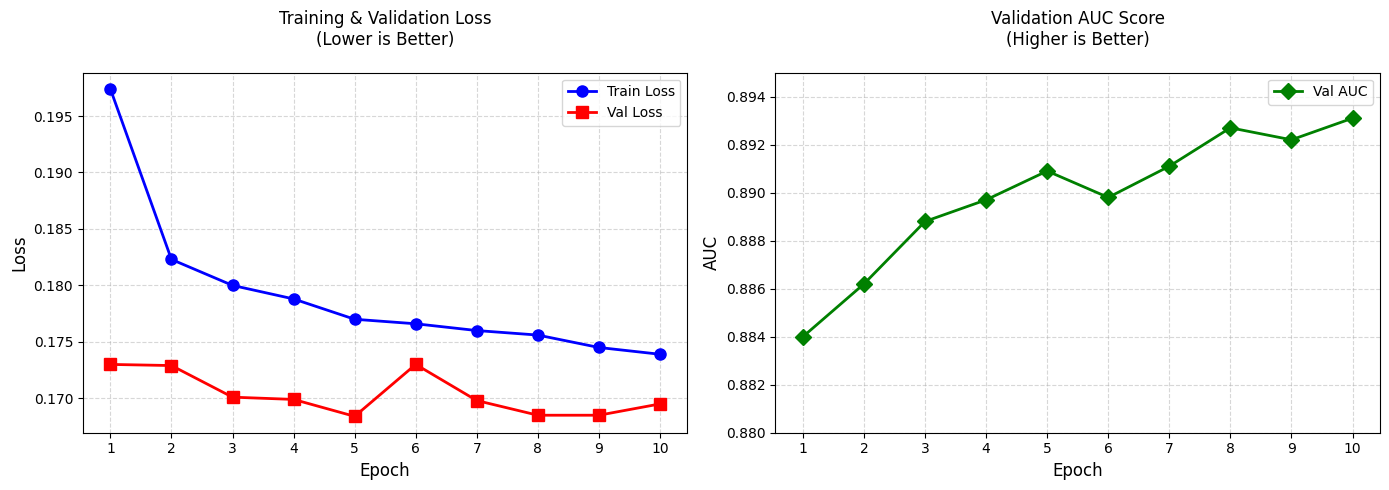

In [ ]:
plt.figure(figsize=(14, 5))

# Loss function
plt.subplot(1, 2, 1)
plt.plot(log['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
plt.plot(log['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=8)
plt.title("Training & Validation Loss\n(Lower is Better)", fontsize=12, pad=20)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(np.arange(10), np.arange(1, 11))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# AUC curve
plt.subplot(1, 2, 2)
plt.plot(log['val_auc'], 'g-D', label='Val AUC', linewidth=2, markersize=8)
plt.title("Validation AUC Score\n(Higher is Better)", fontsize=12, pad=20)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.xticks(np.arange(10), np.arange(1, 11))
plt.ylim(0.88, 0.895)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('manual_training_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,} samples")

Train: 36,502 | Val: 4,563 | Test: 4,563 samples


Load the best model for the evaluation of the test set

In [ ]:
def load_and_evaluate(model_path, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiLabelClassifier(input_dim=1376).to(device)
    model.load_state_dict(torch.load(model_path))

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()
test_preds, test_labels = load_and_evaluate('best_model.pth', test_loader)

## 7.2 AUC radar maps of various categories

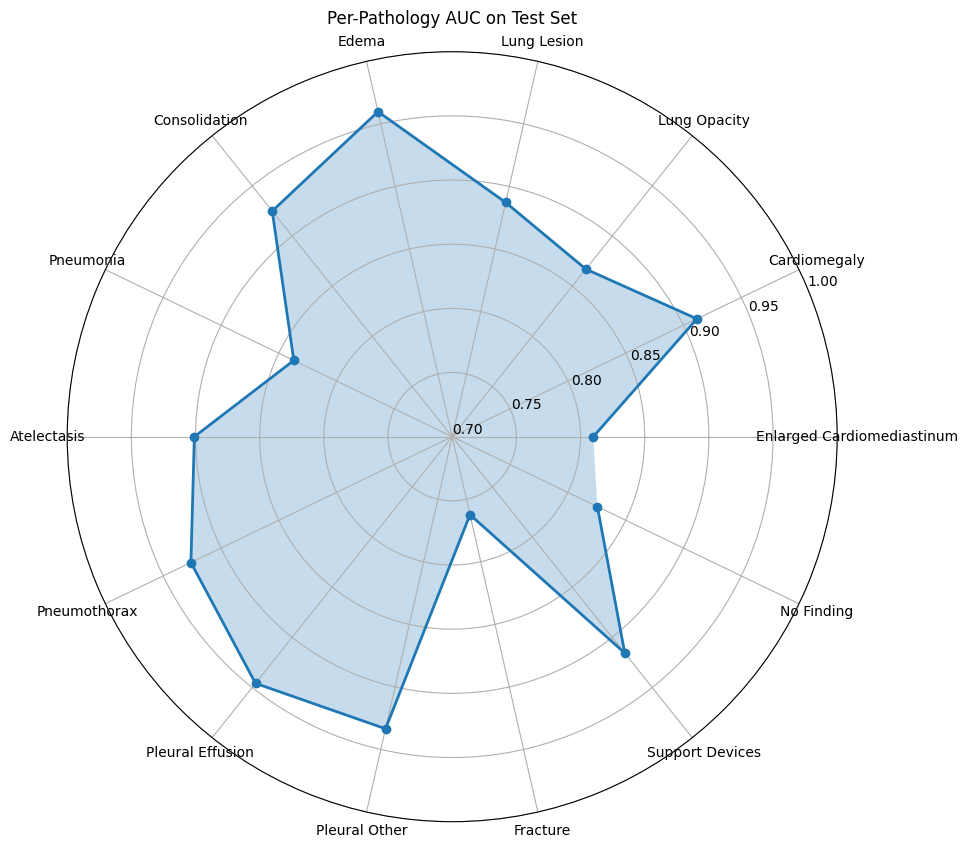

In [ ]:

from sklearn.metrics import roc_auc_score
import numpy as np


pathologies = train_dataset.pathologies
auc_scores = []


for i in range(len(pathologies)):
   mask = ~np.isnan(test_labels[:, i])
   if mask.sum() > 0:
       auc = roc_auc_score(test_labels[:, i][mask], test_preds[:, i][mask])
       auc_scores.append(auc)
   else:
       auc_scores.append(np.nan)

angles = np.linspace(0, 2*np.pi, len(pathologies), endpoint=False)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, auc_scores, 'o-', linewidth=2)
ax.fill(angles, auc_scores, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, pathologies)
ax.set_ylim(0.7, 1.0)
ax.set_title('Per-Pathology AUC on Test Set', pad=20)
plt.show()

## 7.3 Confusion matrix

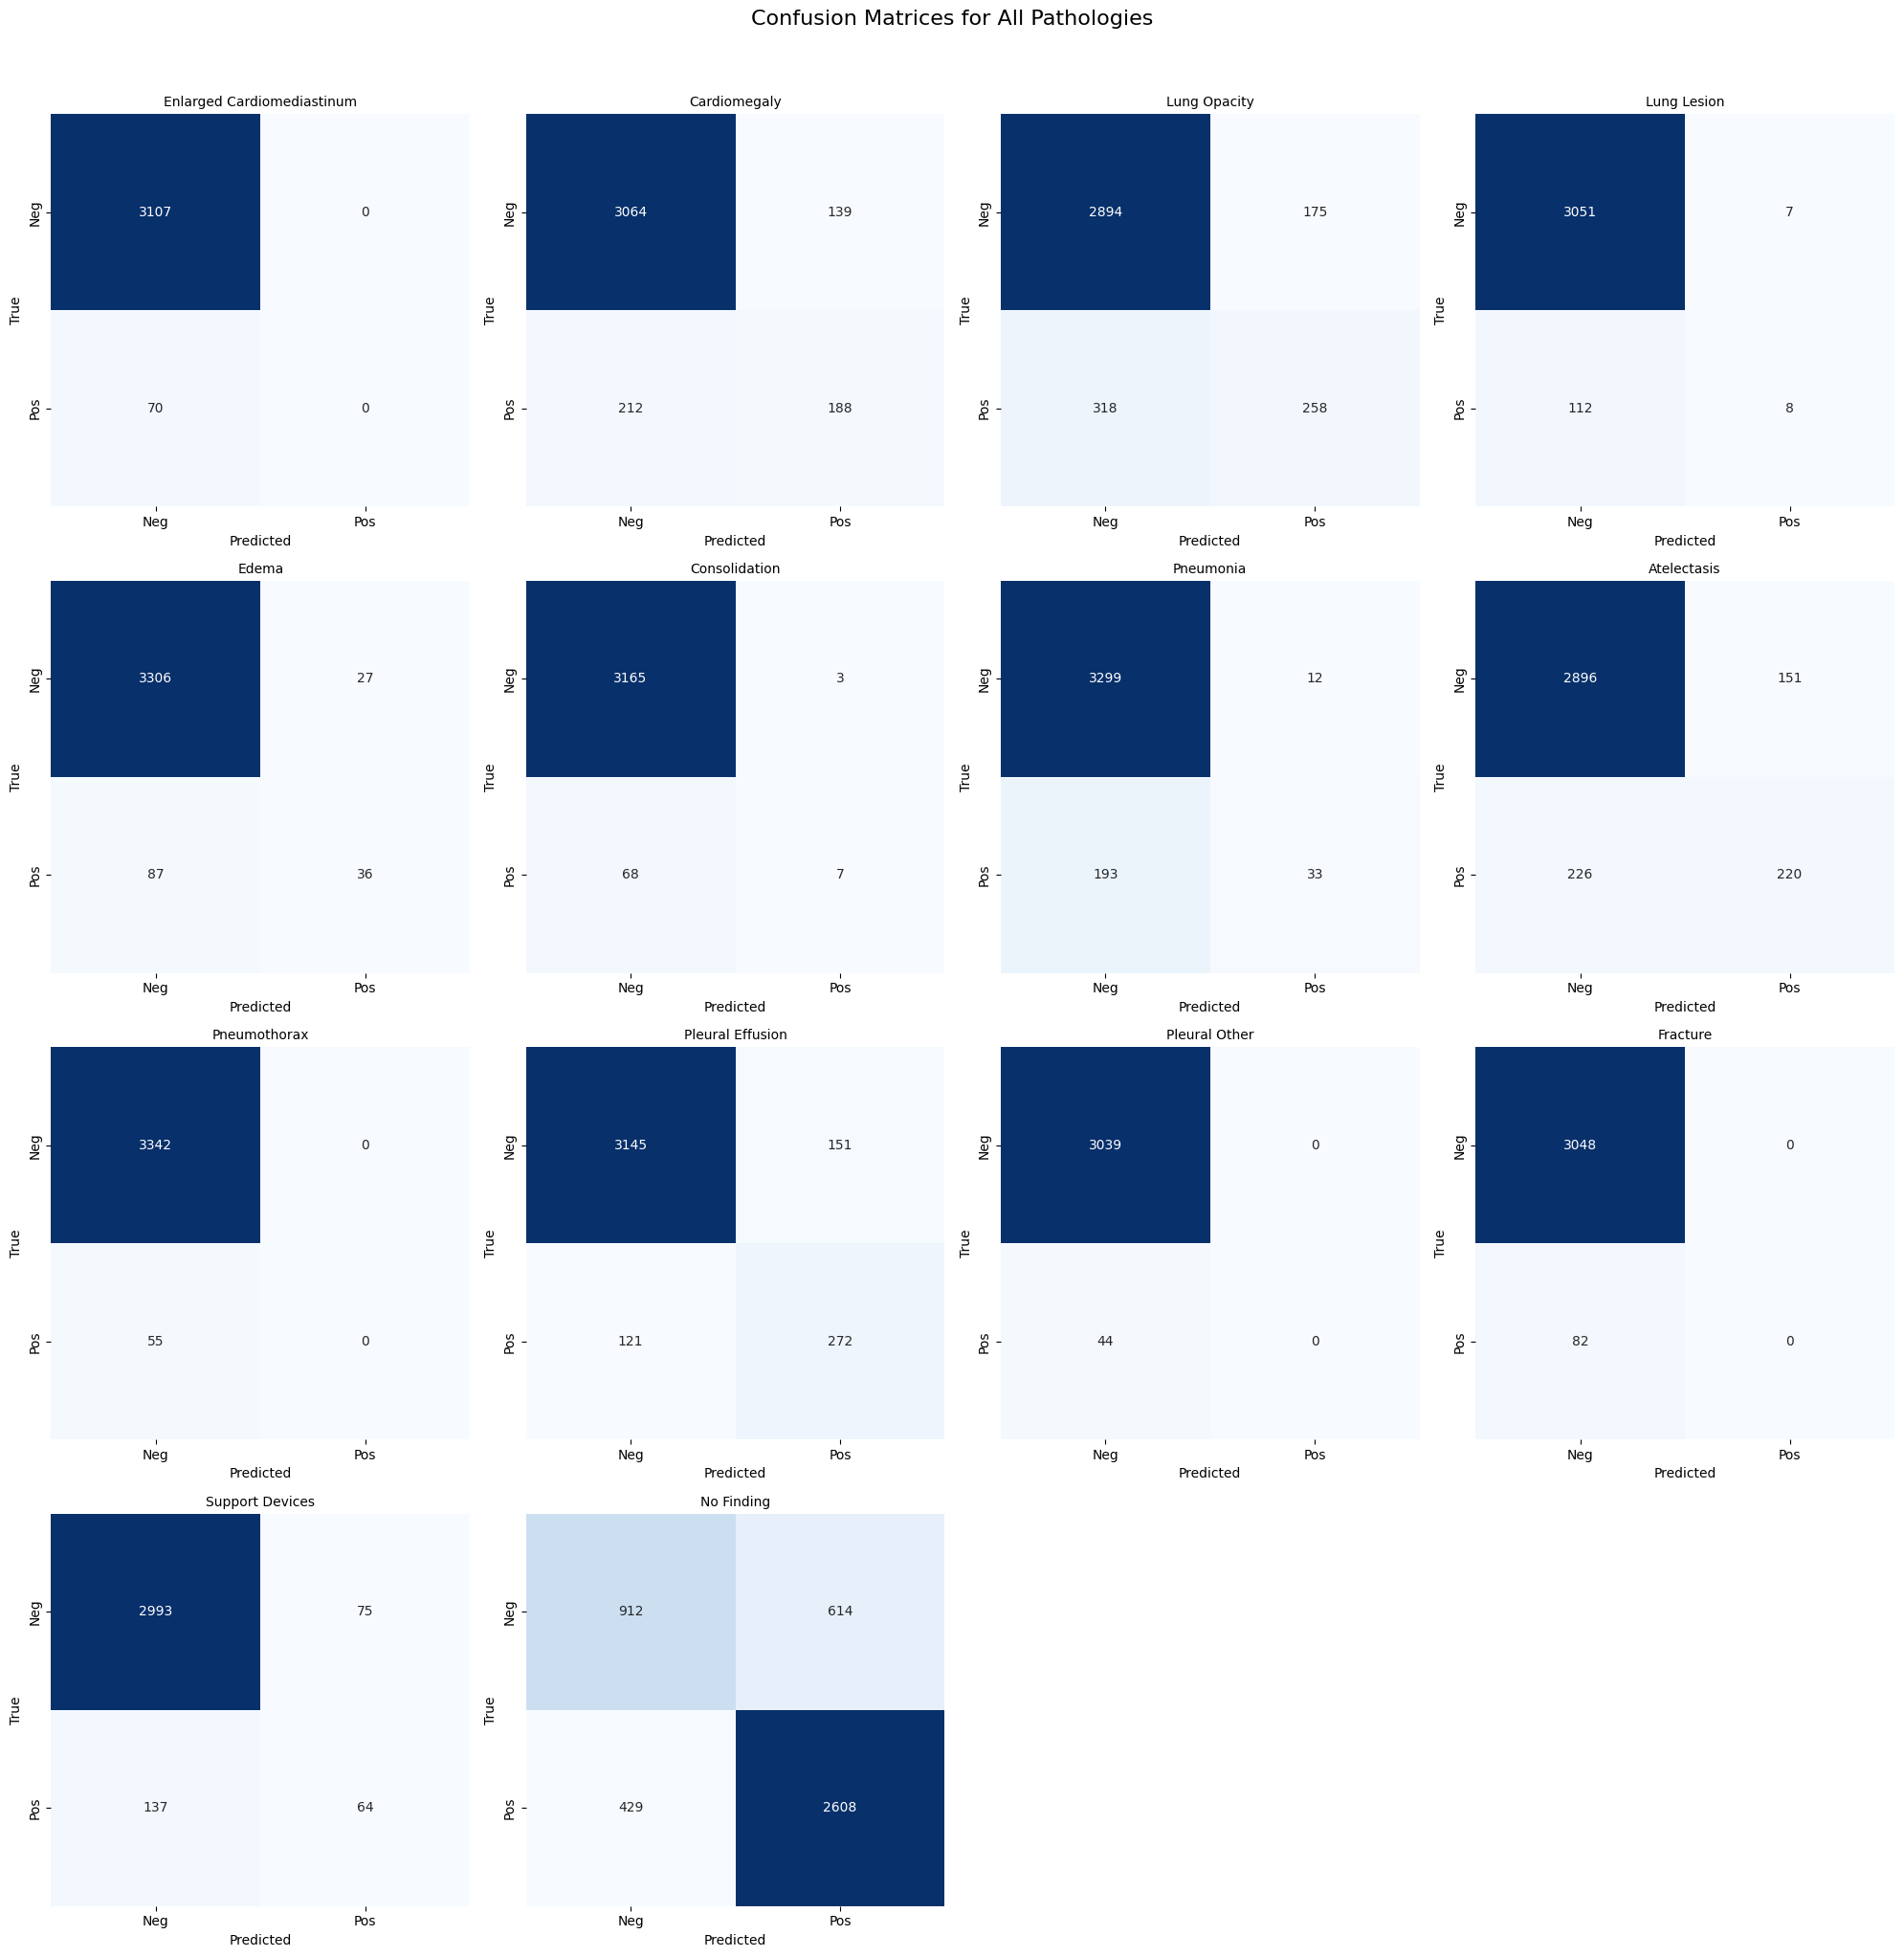

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
    ]

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Confusion Matrices for All Pathologies', fontsize=16, y=1.02)

axes = axes.ravel()

for i, pathology in enumerate(pathologies):
    idx = pathologies.index(pathology)
    mask = ~np.isnan(test_labels[:, idx])
    y_true = test_labels[:, idx][mask] > 0.5
    y_pred = test_preds[:, idx][mask] > 0.5
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'],
                cbar=False, ax=axes[i])

    axes[i].set_title(pathology, fontsize=10)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
for j in range(len(pathologies), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('all_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

 ## 7.4 Analysis of Predicted Probability Distribution

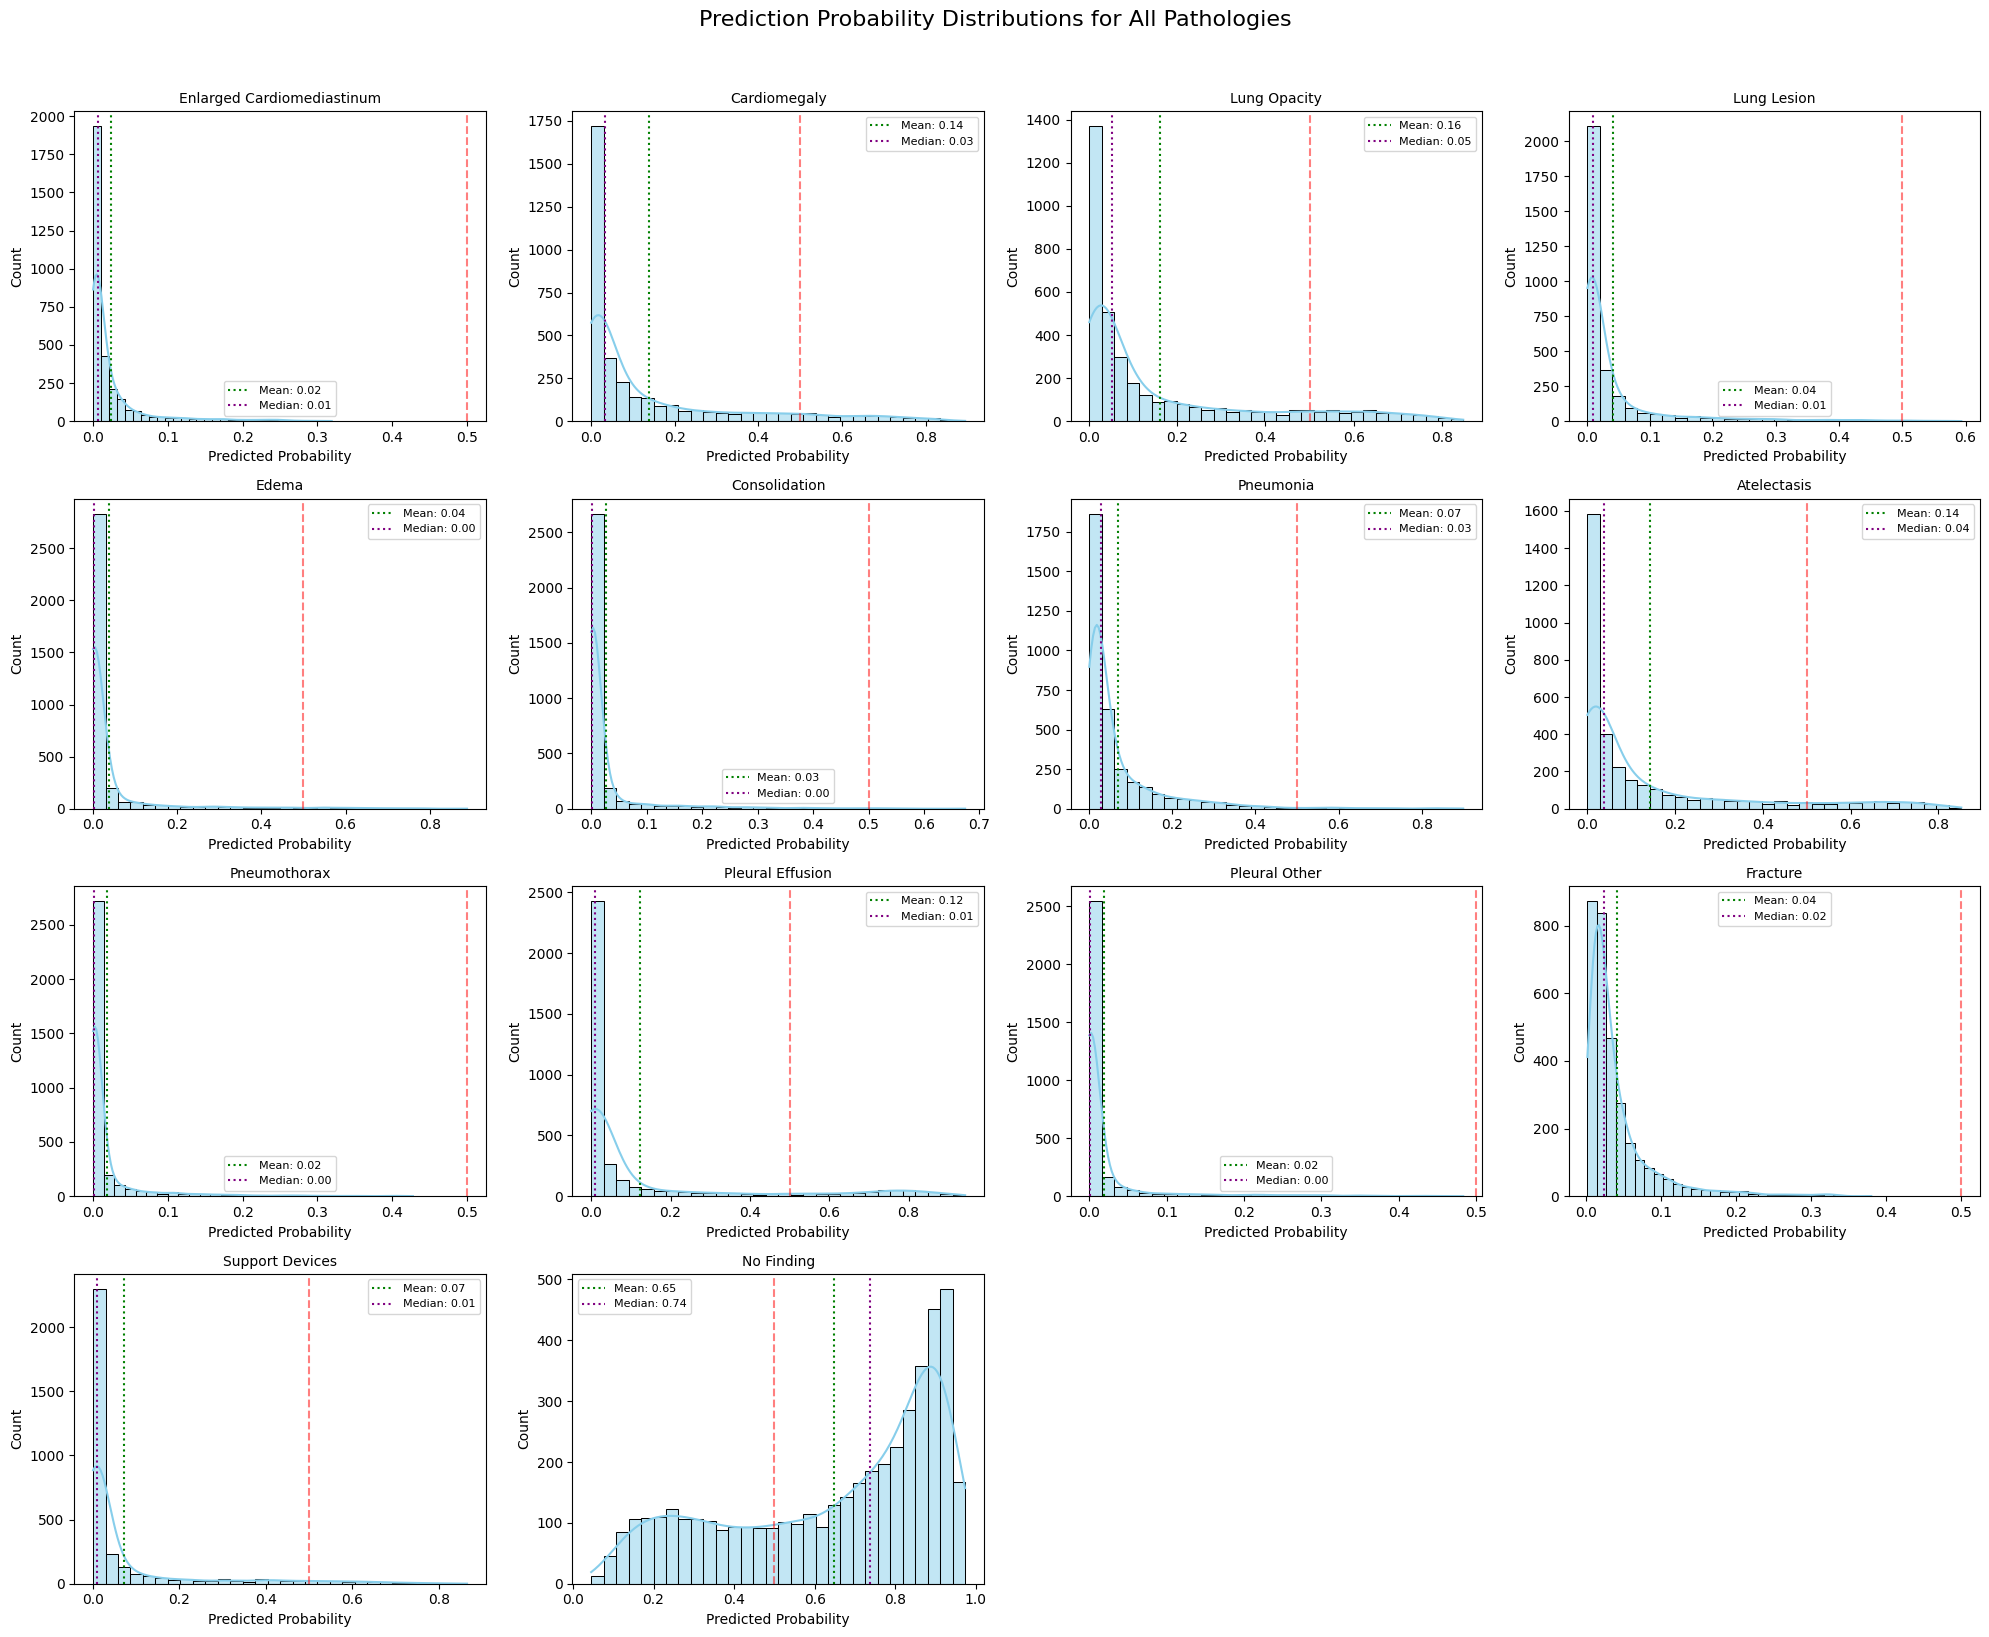

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_pathologies = len(pathologies)
ncols = 4
nrows = int(np.ceil(n_pathologies / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*4))
fig.suptitle('Prediction Probability Distributions for All Pathologies', fontsize=16, y=1.02)

axes = axes.ravel()

for i, pathology in enumerate(pathologies):
    mask = ~np.isnan(test_labels[:, i])
    probs = test_preds[mask, i]
    sns.histplot(probs, bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].axvline(0.5, color='red', linestyle='--', alpha=0.5)
    mean_val = np.mean(probs)
    median_val = np.median(probs)
    axes[i].axvline(mean_val, color='green', linestyle=':', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='purple', linestyle=':', label=f'Median: {median_val:.2f}')
    axes[i].set_title(pathology, fontsize=10)
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Count')
    axes[i].legend(fontsize=8)

for j in range(len(pathologies), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('all_probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.5 Categories Correlation Analysis

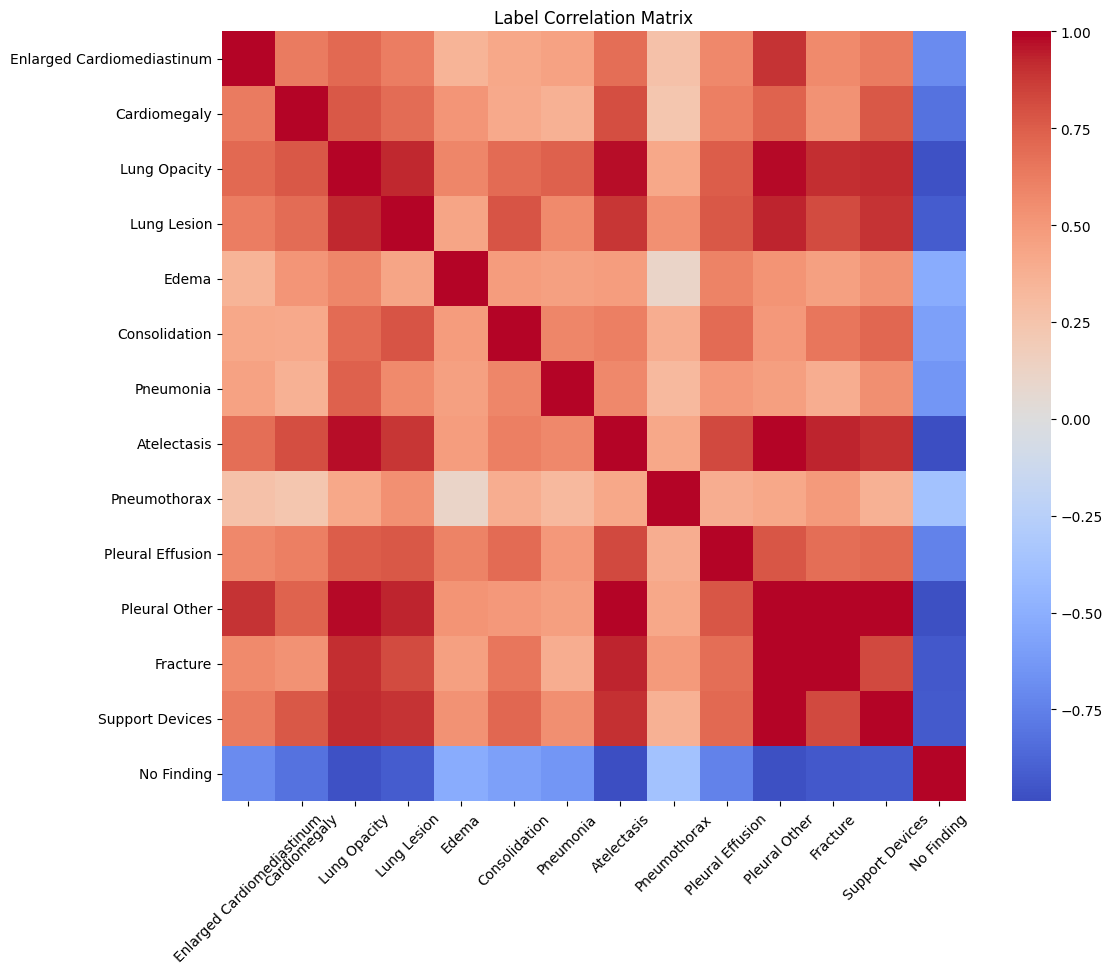

In [ ]:
co_occurrence = np.zeros((len(pathologies), len(pathologies)))
for i in range(len(pathologies)):
    for j in range(len(pathologies)):
        mask = ~np.isnan(test_labels[:, i]) & ~np.isnan(test_labels[:, j])
        co_occurrence[i,j] = np.corrcoef(test_labels[:, i][mask], test_labels[:, j][mask])[0,1]

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap='coolwarm', center=0,
            xticklabels=pathologies, yticklabels=pathologies)
plt.title('Label Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()